## Analysis of Crop Prices Over 2023

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import *

import os

## Building Correlation Matrix

In [4]:
ci = {}
crop_name = []
prices = []
all_dates = pd.date_range(start='2023-01-01', end='2023-12-31')
all_dates_df = pd.DataFrame({'arrival_date': all_dates})

for i,each in enumerate(os.listdir("data/crops/")):
    temp = pd.read_csv("data/crops/" + each)
    temp['arrival_date'] = pd.to_datetime(temp['arrival_date'], dayfirst=True)
    am_prices = temp.groupby('arrival_date')['modal_price'].mean().reset_index()
    average_prices = pd.merge(all_dates_df, am_prices, how='left', on='arrival_date')
    average_prices['modal_price'] = average_prices['modal_price'].ffill()
    name = (' '.join(each.split('.')[0].split('_')[:-1]))
    ci[name] = i
    crop_name.append(name)
    prices.append(np.array(average_prices["modal_price"].values))
    
    
prices = np.array(prices)

In [5]:
row_means = np.nanmean(prices, axis=1)
nan_indices = np.isnan(prices)
prices_no_nan = np.where(nan_indices, np.expand_dims(row_means, axis=1), prices)

correlation_matrix = np.corrcoef(prices_no_nan)

In [17]:
with plt.ioff():
    cluster = sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(12, 10), row_cluster=True, col_cluster=True)
    x_axis_labels_order = cluster.dendrogram_col.reordered_ind
reordered_matrix = correlation_matrix[:, x_axis_labels_order][x_axis_labels_order, :]

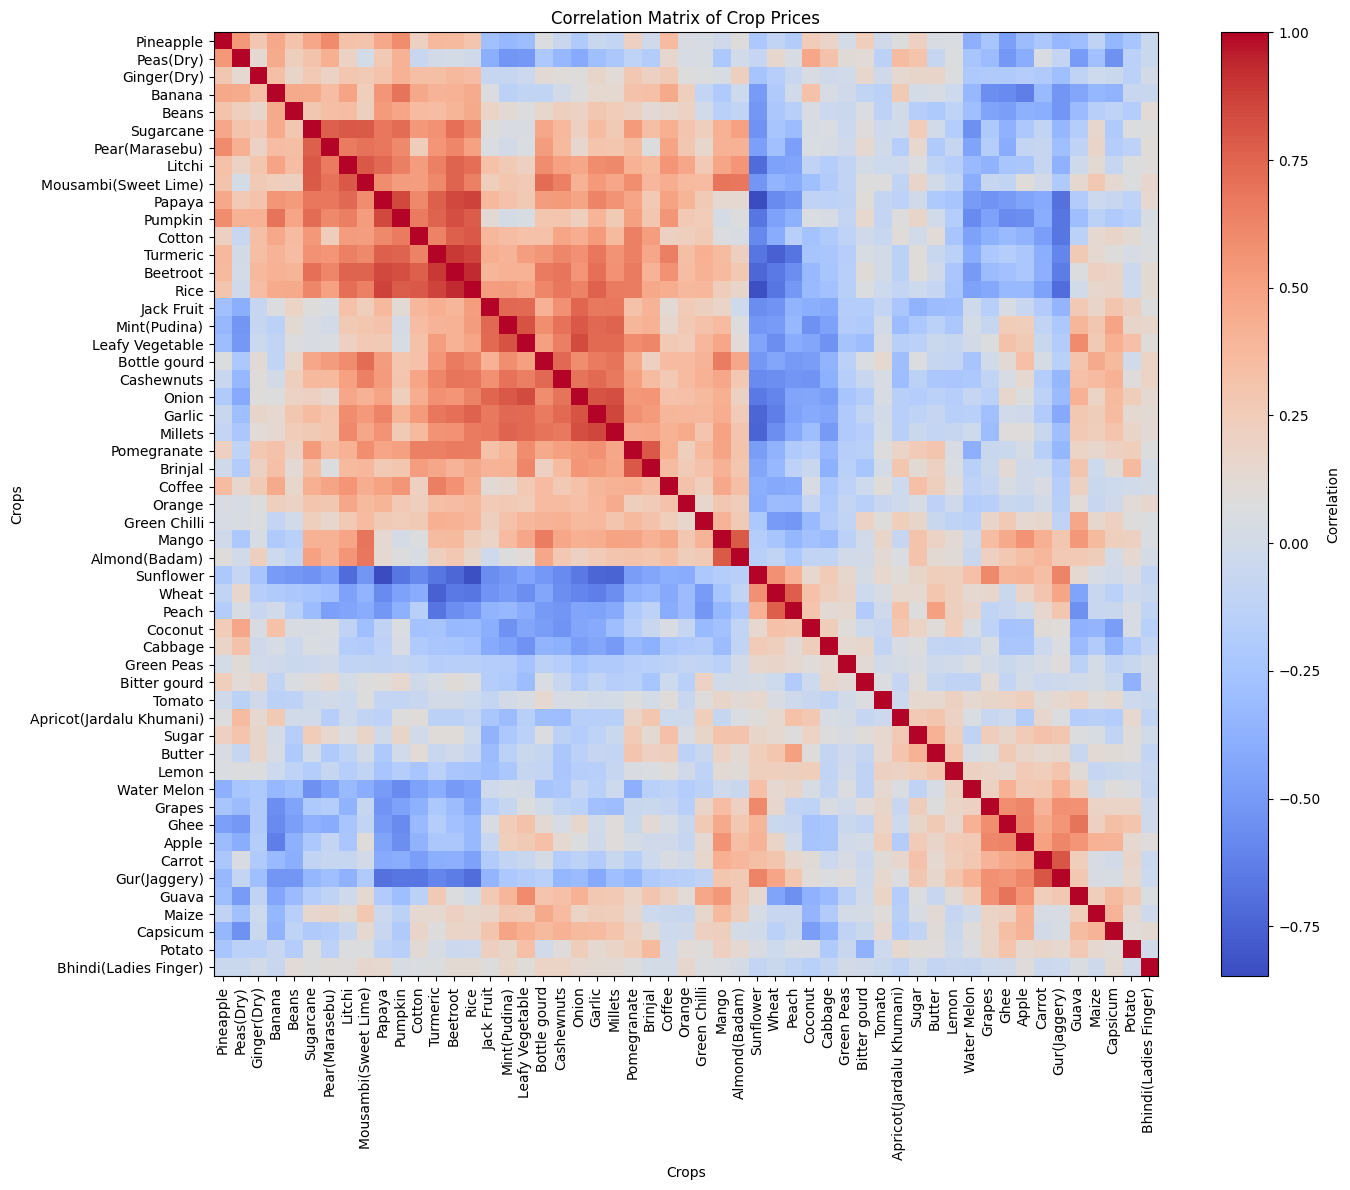

In [7]:
plt.figure(figsize=(15, 12))
plt.imshow(reordered_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Crop Prices')
plt.xlabel('Crops')
plt.ylabel('Crops')
plt.xticks(np.arange(len(ci)), ci, rotation=90)
plt.yticks(np.arange(len(ci)), ci)
plt.tight_layout()
plt.ion()
plt.show()

## Highly Correlated / Highly Uncorrelated Items

In [8]:
hpcp = []
hncp = []

threshold = 0.8

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        corr_coef = correlation_matrix[i, j].round(2)
        if corr_coef > threshold:
            hpcp.append((crop_name[i], crop_name[j], corr_coef))
        elif corr_coef < -threshold:
            hncp.append((crop_name[i], crop_name[j], corr_coef))

print("Pairs with correlation coefficient > 0.8:")
for pair in hpcp:
    print(pair)

print("\nPairs with correlation coefficient < -0.8:")
for pair in hncp:
    print(pair)

Pairs with correlation coefficient > 0.8:
('Peas(Dry)', 'Onion', 0.81)
('Ginger(Dry)', 'Cabbage', 0.85)
('Ginger(Dry)', 'Carrot', 0.85)
('Ginger(Dry)', 'Gur(Jaggery)', 0.86)
('Rice', 'Garlic', 0.85)
('Rice', 'Butter', 0.81)
('Onion', 'Butter', 0.84)
('Garlic', 'Butter', 0.82)
('Cabbage', 'Carrot', 0.82)
('Cabbage', 'Gur(Jaggery)', 0.93)
('Cabbage', 'Potato', 0.9)
('Gur(Jaggery)', 'Potato', 0.86)

Pairs with correlation coefficient < -0.8:
('Ginger(Dry)', 'Cotton', -0.85)
('Cotton', 'Gur(Jaggery)', -0.83)


## Varation in Prices 

In [13]:
fruits = ['Pineapple', 'Banana', 'Pear(Marasebu)', 'Litchi', 'Mousambi(Sweet Lime)', 'Papaya', 'Jack Fruit', 'Orange', 'Mango', \
            'Pomegranate', 'Apple', 'Peach', 'Coconut', 'Lemon', 'Water Melon', 'Grapes', 'Apricot(Jardalu Khumani)', 'Guava']

vegetables = ['Peas(Dry)', 'Ginger(Dry)', 'Beans', 'Pumpkin', 'Turmeric', 'Beetroot', 'Leafy Vegetable', 'Bottle gourd', 'Onion', \
                'Garlic', 'Brinjal', 'Green Chilli', 'Cabbage', 'Green Peas', 'Bitter gourd', 'Tomato', 'Mint(Pudina)', 'Capsicum', \
                    'Bhindi(Ladies Finger)', 'Carrot', 'Potato']

grains_cereals = ['Rice', 'Millets', 'Wheat', 'Maize', 'Coffee']

others = ['Cotton', 'Cashewnuts', 'Almond(Badam)', 'Sugar', 'Sugarcane', 'Butter', 'Ghee', 'Sunflower', 'Gur(Jaggery)']

In [14]:
df_prices = pd.DataFrame(prices_no_nan, columns=[str(i) for i in range(1,366)])  
df_prices['Crop'] = crop_name

def categorize_crop(crop_name):
    if crop_name in fruits:
        return 'Fruits'
    elif crop_name in vegetables:
        return 'Vegetables'
    elif crop_name in grains_cereals:
        return 'Grains & Cereals'
    elif crop_name in others:
        return 'Others'
    else:
        return 'Unknown'

df_prices['Category'] = df_prices['Crop'].apply(categorize_crop)
df_melted = df_prices.melt(id_vars=['Category', 'Crop'], var_name='Day', value_name='Modal_Price')

In [15]:
crop_means = df_melted.groupby('Crop')['Modal_Price'].mean()
threshold = 0.1 

for crop, mean in crop_means.items():
    crop_rows = df_melted['Crop'] == crop
    df_melted.loc[crop_rows & (df_melted['Modal_Price'] < threshold), 'Modal_Price'] = mean

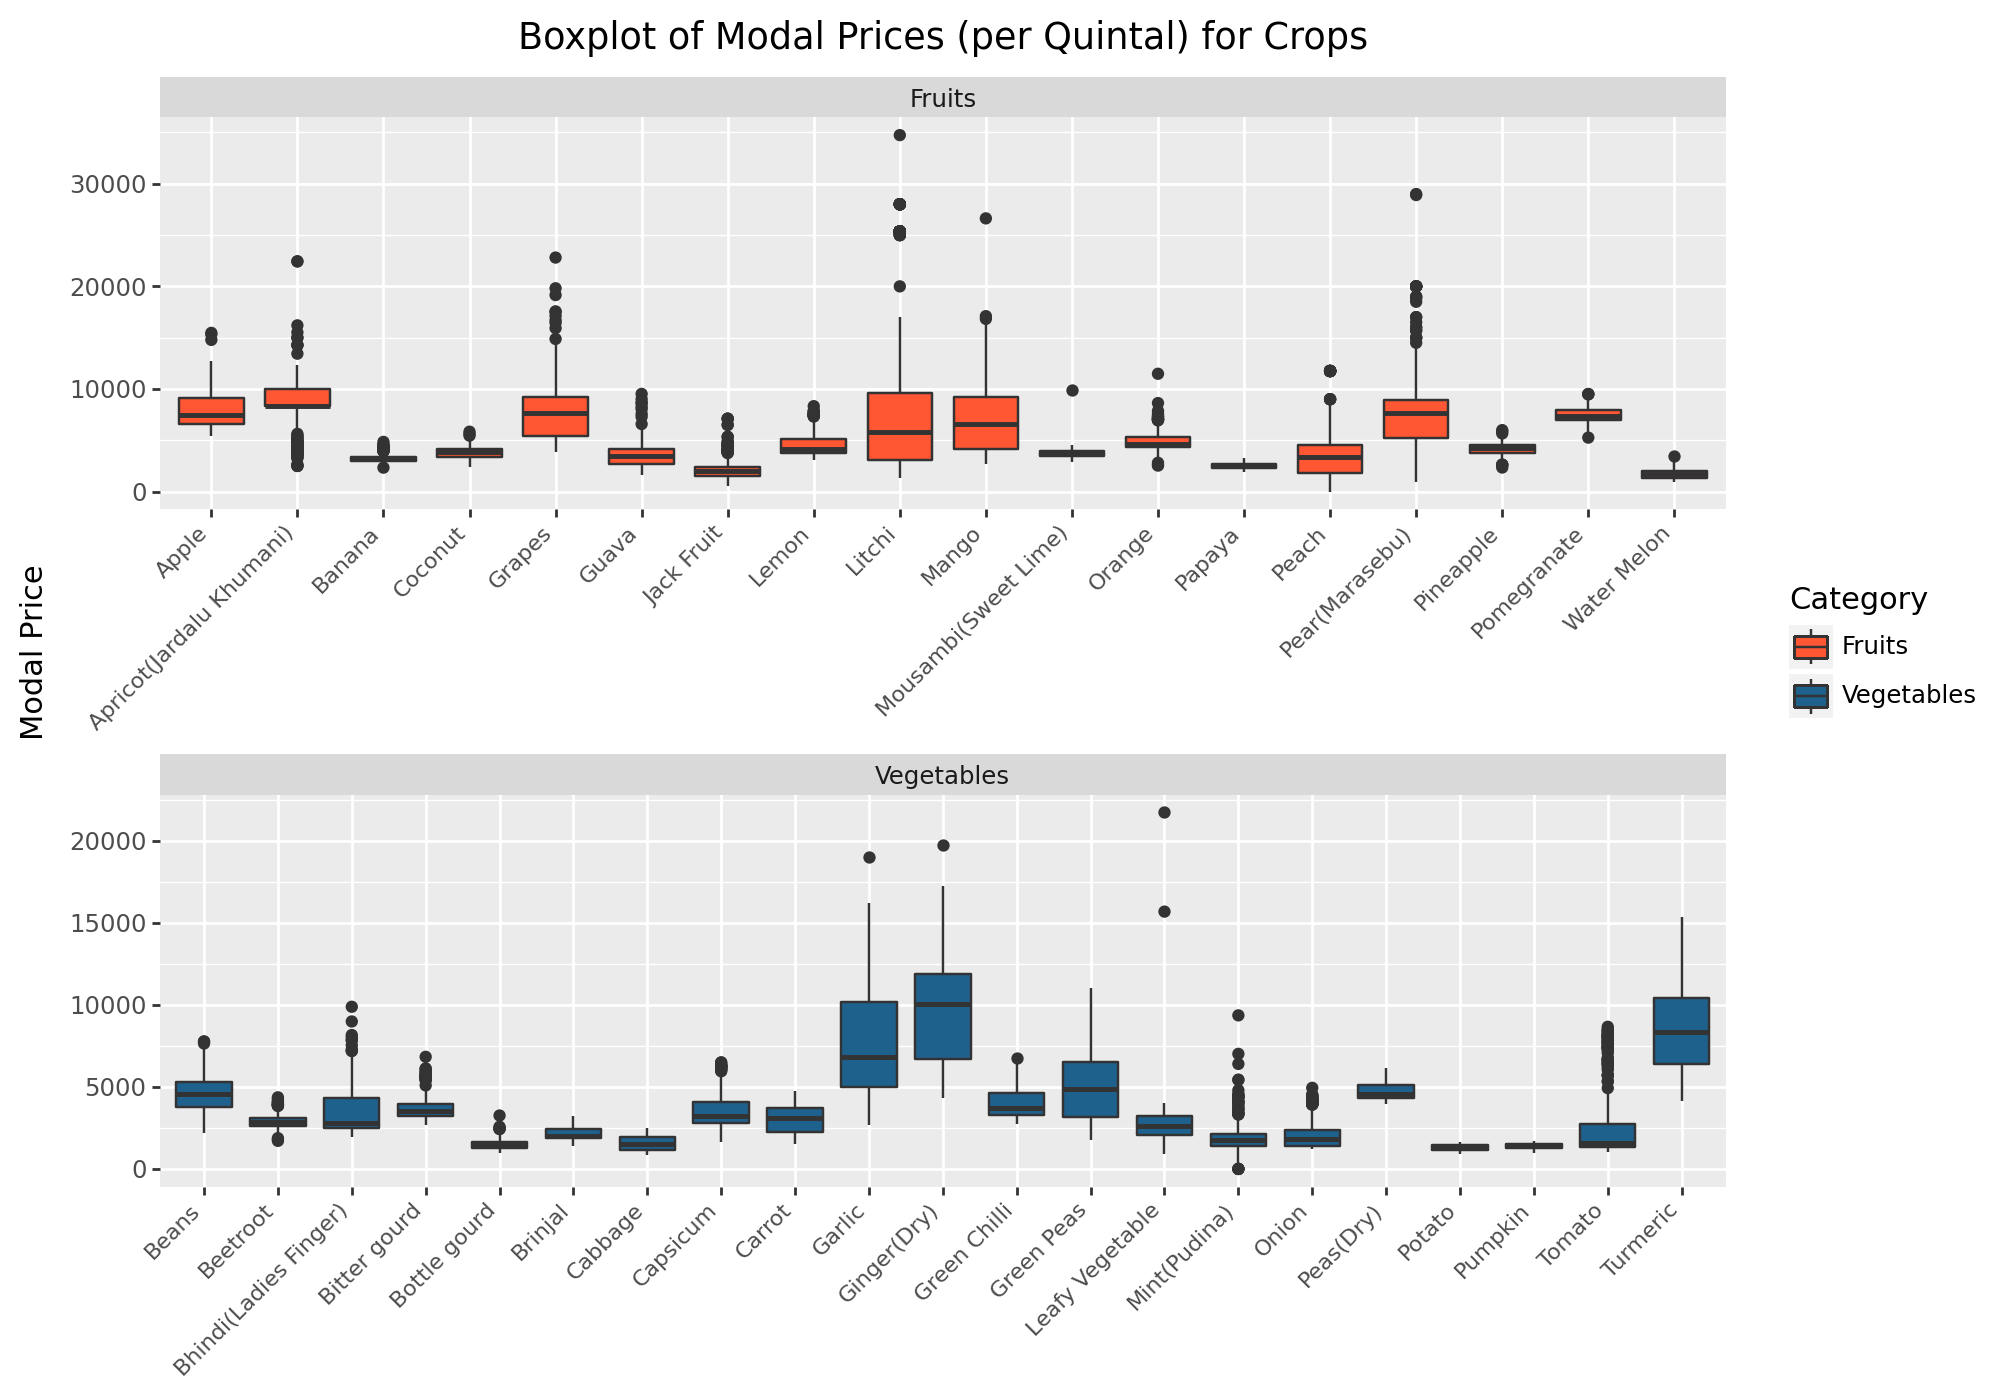

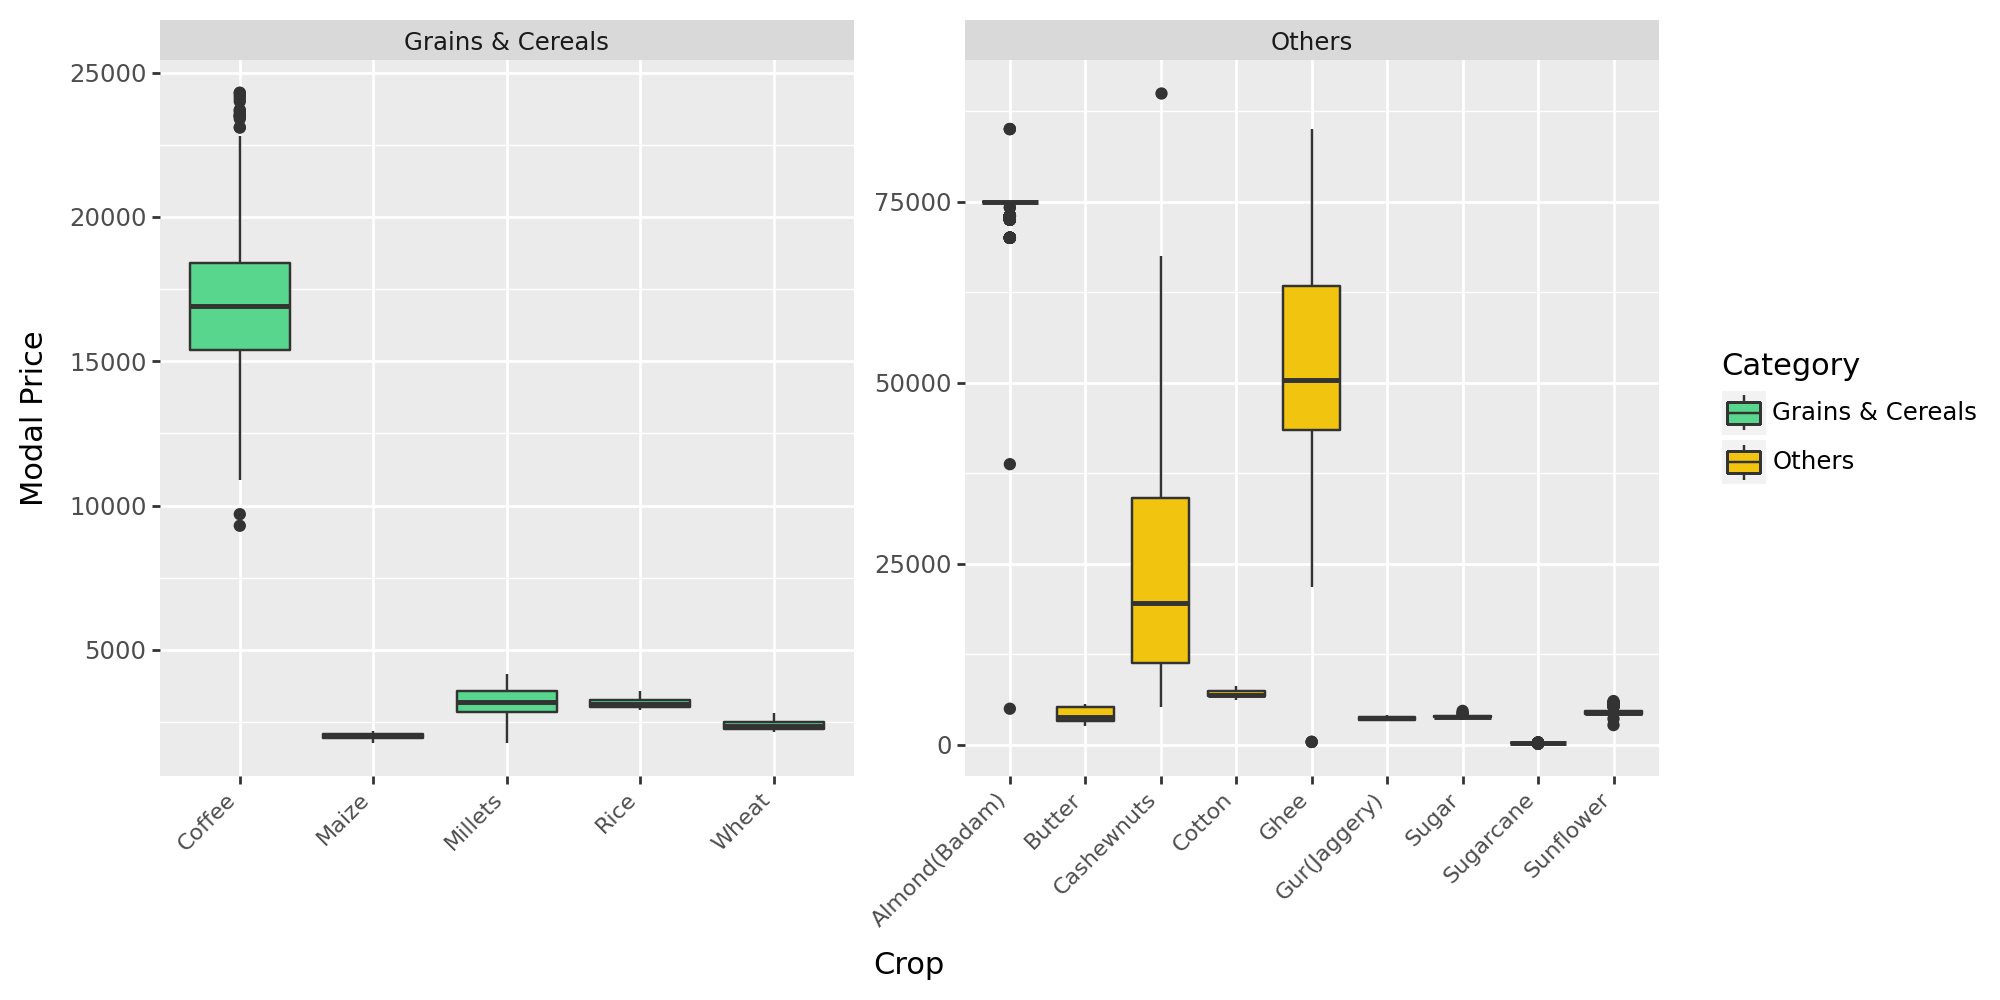

In [16]:
custom_color_palette = {
    'Fruits': '#FF5733', 
    'Vegetables': '#1F618D',  
    'Grains & Cereals': '#58D68D',  
    'Others': '#F1C40F' 
}

df_split1 = df_melted[(df_melted["Category"] == "Fruits") | (df_melted["Category"] == "Vegetables")]
df_split2 = df_melted[(df_melted["Category"] == "Grains & Cereals") | (df_melted["Category"] == "Others")]


plot = (
    ggplot(df_split1, aes(x='Crop', y='Modal_Price', fill='Category')) +
    geom_boxplot() +
    facet_wrap('~ Category', scales='free', nrow=2, ncol=1) +  
    theme(axis_text_x=element_text(rotation=45, hjust=1, size=8)) +  
    labs(x='',y='Modal Price', title='Boxplot of Modal Prices (per Quintal) for Crops') +
    scale_fill_manual(values=custom_color_palette) +  
    theme(figure_size=(10, 7))  
)

plot2 = (
    ggplot(df_split2, aes(x='Crop', y='Modal_Price', fill='Category')) +
    geom_boxplot() +
    facet_wrap('~ Category', scales='free', nrow=1, ncol=2) +  
    theme(axis_text_x=element_text(rotation=45, hjust=1, size=8)) +  
    labs(x='Crop',y='Modal Price') +
    scale_fill_manual(values=custom_color_palette) +  
    # theme_minimal() +
    theme(figure_size=(10, 5))  
)

# Show the plot
plot.show()
plot2.show()